In [1]:
!pip install hdbscan
!pip install dbscan1d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 11.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039288 sha256=d1907318b0d54cce05e7450971c3244d7ab954b3f0c22dd08c2ca961032f79c3
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.6
    Uninstalling Cython-3.0.6:
      Successfully uninstalled Cython-3.0.6


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
import warnings
from dbscan1d.core import DBSCAN1D

#####################################################

df = pd.read_fwf('/content/lorenz.txt')

x = np.float32(np.array(df.iloc[:,0])[13000:23000])

y_true = np.float32(np.array(df.iloc[:,0])[23000:23600])

pattern_set = [[i1, i2, i3] for i1 in np.arange(1, 11, 1) # Sample
               for i2 in np.arange(1, 11, 1)
               for i3 in np.arange(1, 11, 1)]

def ones_patters(a, n, pat = None):
    if pat == None:
        pat = np.int_(np.ones(n))
    b = np.int_(np.append([0], np.cumsum(pat)))
    l = []
    for i in range(a.shape[0] - np.sum(pat)):
        l.append(a[b].reshape(1, -1))
        b = b + 1

    return np.concatenate(l, axis = 0)

#####################################################
warnings.filterwarnings("ignore")

# Extract Samples
Ca_set_direct  = np.array([ones_patters(x, 3, pat = pattern) for pattern in pattern_set])

# Baseline Prediction

In [3]:
def C(pattern, x):  # Return data based on the pattern set

    c_ = len(x) - np.cumsum(pattern[::-1])
    return x[c_][::-1]


def Possible_predictions(pattern, x, Ca, eps):
    C_ = C(pattern, x).tolist()   # Extract last elements based on the patterns [x1, x2, x3]
    C_ = [np.float32(i) if i != 'N' else 'N' for i in C_]   # check if the element is predictable
    TrCa = Ca[:,:-1]

    if 'N' in C_:
        return []
    else:
        d = distance.cdist(TrCa, [C_], 'euclidean')
        closed_mot_index = np.where(d < eps)[0]
        Possible_predictions_ = Ca[closed_mot_index, -1]

        return Possible_predictions_

def prediction_one_step(Q, sigma, tresh_size1, tresh_diff, eps_cl, min_samples_cl):
    Qreshape = Q.reshape(len(Q),1)

    # DBSCAN1D clustering
    c = DBSCAN1D(eps=eps_cl, min_samples=min_samples_cl)
    l = c.fit_predict(Qreshape)   # Fit the model
    count_cl = np.array(np.unique(l, return_counts = True)).T   # number of samples in each cluster

    count_cl_without_noize = count_cl[~np.isin(count_cl[:,0],[-1])]  # remove noise (class -1)

    if count_cl_without_noize.shape[0] == 0:    # not predictable if there is no cluster

        return 'N'
    else:

        # Sort clusters based on the number of samples in each cluster
        count_cl_without_noize_sorted = count_cl_without_noize[np.argsort(count_cl_without_noize[:,1]), :]
#                 print(count_cl_without_noize_sorted)

        # Check the ratio of samples for the biggest cluster to all samples
        size1 = count_cl_without_noize_sorted[-1, 1] / Q.size

        if count_cl_without_noize_sorted.shape[0] > 1:
            # Check the second biggest cluster ratio to all samples
            size2 = count_cl_without_noize_sorted[-2, 1] / Q.size
        else:
            size2 = 0

        if size2 != 0:
            # tresh_size1 = 0.4, tresh_diff = 0.2
            if (size1 < tresh_size1) | (size1 - size2 < tresh_diff):   # Don't have enough samples to predict

                return 'N'
            else:
                # Use mean method to calculate the one step prediction ahead
                return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, sigma, 1)[0]
        else:
            if size1 < tresh_size1:

                return 'N'
            else:
                return np.mean(Q[np.where(l == count_cl_without_noize_sorted[-1, 0])]) + np.random.normal(0, sigma, 1)[0]


def Predict_pull(pattern_set, x, pattern_samples, eps=0.01, sigma=0.01, tresh_size1=0.4, tresh_diff=0.2, eps_cl=0.005, min_samples_cl=5):
    Qlist = np.array([Possible_predictions(pattern_set[i], x, pattern_samples[i], eps) for i in  range(len(pattern_set))])
    Q = np.hstack(Qlist)
    if len(Q) == 0:
        return 'N'
    else:

        return prediction_one_step(Q, sigma, tresh_size1, tresh_diff, eps_cl, min_samples_cl)

In [5]:
from tqdm import tqdm
pred = []
T = 50
for t in tqdm(range(T),desc="Predicting"):
    a = Predict_pull(pattern_set, np.append(x, pred), Ca_set_direct, eps=0.005, sigma=0.0, tresh_size1=0.4, tresh_diff=0.2, eps_cl=0.005, min_samples_cl=5)
    pred.append(a)

Predicting: 100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


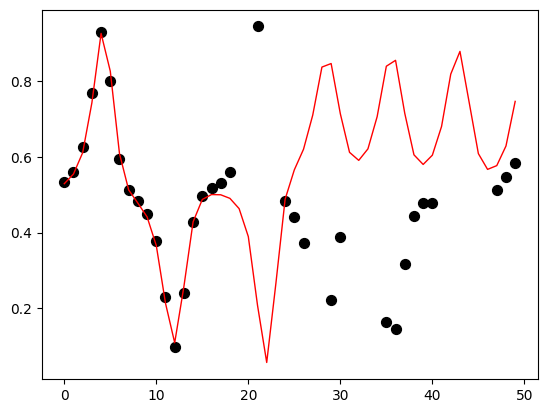

In [6]:
pred_ = [pred[i] if pred[i] != 'N' else np.nan for i in range(T)]
plt.plot(np.arange(T), y_true[:T], color='r', linewidth=1)
plt.scatter(np.arange(T), pred_, color='black', s=50)

# Predicting Weights

In [7]:
from scipy.stats import kurtosis, entropy
from sklearn.preprocessing import StandardScaler

In [56]:
# Training phase
m = 100
x_train = x[:-m]
pattern_matrix_train = np.array([ones_patters(x_train, 3, pat = pattern) for pattern in pattern_set])

In [73]:
import numpy as np
from scipy.stats import kurtosis, entropy
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Function to calculate statistical features from a sequence of numbers
def calculate_distribution_stats(sequence):
    """
    Calculate and return statistical features of a sequence including kurtosis, variance, and entropy.

    :param sequence: An array of numeric values.
    :return: An array containing the kurtosis, variance, and entropy of the sequence.
    """
    sequence_kurtosis = kurtosis(sequence)  # Measure of the "tailedness" of the probability distribution
    sequence_variance = np.var(sequence)    # Measure of the dispersion of values in the sequence

    # Reshape sequence for DBSCAN and calculate entropy
    reshaped_seq = sequence.reshape(len(sequence), 1)
    dbscan_model = DBSCAN(eps=0.005, min_samples=5)
    labels = dbscan_model.fit_predict(reshaped_seq)
    label_probs = np.unique(labels, return_counts=True)[1] / len(labels)
    sequence_entropy = entropy(label_probs)  # Measure of randomness in the label distribution

    return np.array([sequence_kurtosis, sequence_variance, sequence_entropy])

# Function to predict outcomes with weights based on the distance from pattern elements
def predict_with_weights(pattern, sequence, pattern_matrix, eps):
    """
    Predict potential outcomes with weights based on a given pattern and a sequence.

    :param pattern: A specific pattern to match in the sequence.
    :param sequence: The sequence of data to analyze.
    :param pattern_matrix: A matrix representing different patterns.
    :param eps: Epsilon value for distance calculation.
    :return: Weighted predictions based on the proximity to the pattern.
    """
    last_elements = C(pattern, sequence).tolist()  # Function C needs to be defined elsewhere
    last_elements = [np.float32(elem) if elem != 'N' else 'N' for elem in last_elements]

    trimmed_pattern_matrix = pattern_matrix[:, :-1]

    if 'N' in last_elements:
        return np.zeros((0, 2))
    else:
        distances = euclidean_distances(trimmed_pattern_matrix, [last_elements])
        close_indices = np.where(distances < eps)[0]
        predictions = pattern_matrix[close_indices, -1].reshape(-1, 1)
        weights = (eps - distances[close_indices]) / eps
        weighted_predictions = np.concatenate([predictions, weights], axis=1)

        return weighted_predictions

# Function to predict an outcome based on patterns and features
def predict_one_step(patterns, sequence, pattern_samples, eps):
    """
    Make a one-step prediction by aggregating weighted predictions from multiple patterns.

    :param patterns: A list of patterns to be matched in the sequence.
    :param sequence: The sequence of data for prediction.
    :param pattern_samples: Sample data for each pattern.
    :param eps: Epsilon value for distance calculation in pattern matching.
    :return: A weighted sum prediction and distribution features of the prediction results.
    """
    combined_results = np.zeros((0, 2))
    for pattern_index, pattern in enumerate(patterns):
        pattern_matrix = pattern_matrix_train[pattern_index]  # Assumes pattern_matrix_train is defined
        predictions = predict_with_weights(pattern, sequence, pattern_matrix, eps)
        combined_results = np.concatenate([combined_results, predictions], axis=0)

    if combined_results.shape[0] == 0:
        return 'N'

    weighted_sum = np.dot(combined_results[:, 0], combined_results[:, 1]) / np.sum(combined_results[:, 1])
    distribution_features = calculate_distribution_stats(combined_results[:, 0])

    return weighted_sum, distribution_features


max_allowed_error = 0.05
train_features = []
train_targets = []
train_predictions = []

for i in range(m):
    prediction, features = predict_one_step(pattern_set, np.append(x_train, train_predictions), pattern_matrix_train, eps=0.005)
    train_predictions.append(prediction)

    if prediction != 'N':
        train_features.append(features)
        if abs(prediction - x[-m + i]) > max_allowed_error:
            train_targets.append(0)  # Non-predictable point
        else:
            train_targets.append(1)  # Predictable point

train_features = np.array(train_features)
train_targets = np.array(train_targets)

# Model training
scaler = StandardScaler()
scaler.fit(train_features)
train_features_std = scaler.transform(train_features)




# Results

[0.5320848085680112, 0.5600009677193031, 0.6219330902917309, 0.7581217911105018, 0.9121427639602033, 0.8012629784345733, 0.6028073953678437, 0.5168209681766256, 0.48576241944382953, 0.4555576661430348, 0.39099795030905715, 0.25657393785900673, 0.1294484838667704, 0.23789803774527635, 0.41695166202427114, 0.4922722829789422, 0.515937618140864, 0.533154317961924, 0.5624015813829698, 0.6307095598344341, 0.7576192338114489, 0.8573623208190637, 0.7288211745732904, 0.5657587318057931, 0.49389823353811985, 0.4575013091686963, 0.4034342872874572, 0.3018079300757531, 0.18273486936692462, 0.22709618678659324, 0.37877678090727995, 0.459667124881878, 0.47903162793643755, 0.46894788884061583, 0.4373440146626649, 0.34691811081816437, 0.20996139026076574, 0.19280114336865495, 0.3379857143049958, 0.46274200967713724, 0.5047224181029479, 0.5317229206100522, 0.5553913122383672, 0.6060624756648095, 0.7120685605098042, 0.8376997793689901, 0.7635566927494314, 0.6058822494357509, 0.5211158083285297, 0.49322

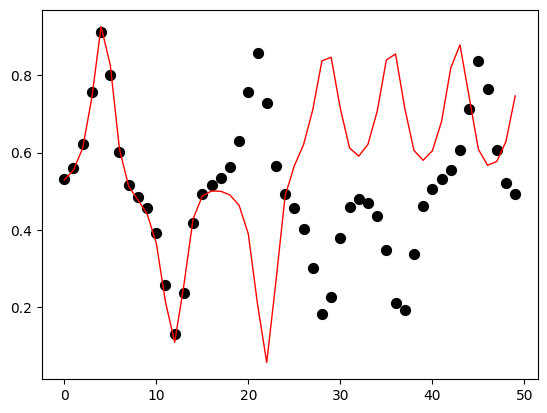

In [74]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(train_features_std, train_targets)

# Final prediction function
def final_prediction(patterns, sequence, pattern_matrices, eps):
    result = predict_one_step(patterns, sequence, pattern_matrices, eps)
    if result == 'N':
        return 'N'

    standardized_features = scaler.transform([result[1]])
    is_predictable = random_forest_model.predict(standardized_features)[0]
    return result[0] if is_predictable else 'N'

final_predictions = []
T = 50
for t in range(T):
    prediction = final_prediction(pattern_set, np.append(x, final_predictions), pattern_matrix_train, eps=0.01)
    final_predictions.append(prediction)

print(final_predictions)

# Plotting
final_predictions_processed = [final_predictions[i] if final_predictions[i] != 'N' else np.nan for i in range(T)]
plt.plot(np.arange(T), y_true[:T], color='r', linewidth=1)
plt.scatter(np.arange(T), final_predictions_processed, color='black', s=50)

# Mean Absolute Error
def calculate_mae(y_true, y_pred, decimals=4):
    return np.around(np.nanmean(np.abs(y_true - y_pred)), decimals)

# Mean Squared Error
def calculate_mse(y_true, y_pred, decimals=4):
    return np.around(np.nanmean((y_true - y_pred) ** 2), decimals)

print("MAE:", calculate_mae(y_true[:T], final_predictions_processed))
print("MSE:", calculate_mse(y_true[:T], final_predictions_processed))

[0.5320848085680112, 0.5600009677193031, 0.6219330902917309, 0.7581217911105018, 0.9121427639602033, 0.8012629784345733, 0.6028073953678437, 0.5168209681766256, 0.48576241944382953, 0.4555576661430348, 0.39099795030905715, 0.25657393785900673, 0.1294484838667704, 0.23789803774527635, 0.41695166202427114, 0.4922722829789422, 0.515937618140864, 0.533154317961924, 0.5624015813829698, 0.6307095598344341, 0.7576192338114489, 0.8573623208190637, 0.7288211745732904, 0.5657587318057931, 0.49389823353811985, 0.4575013091686963, 0.4034342872874572, 0.3018079300757531, 0.18273486936692462, 0.22709618678659324, 0.37877678090727995, 0.459667124881878, 0.47903162793643755, 0.46894788884061583, 0.4373440146626649, 0.34691811081816437, 0.20996139026076574, 0.19280114336865495, 0.3379857143049958, 0.46274200967713724, 0.5047224181029479, 0.5317229206100522, 0.5553913122383672, 0.6060624756648095, 0.7120685605098042, 0.8376997793689901, 0.7635566927494314, 0.6058822494357509, 0.5211158083285297, 0.49322

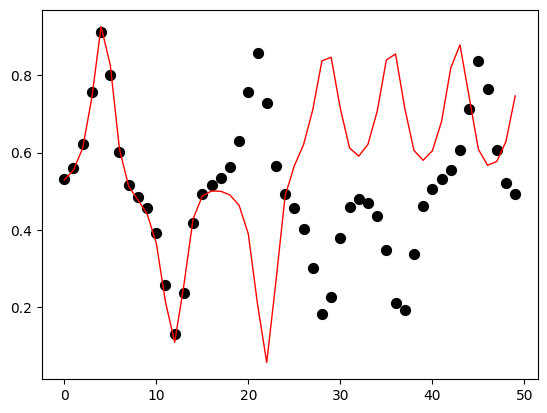

In [75]:
xgboost_model = XGBRegressor(n_estimators=100, random_state=42)
xgboost_model.fit(train_features_std, train_targets)

# Final prediction function
def final_prediction(patterns, sequence, pattern_matrices, eps):
    result = predict_one_step(patterns, sequence, pattern_matrices, eps)
    if result == 'N':
        return 'N'

    standardized_features = scaler.transform([result[1]])
    is_predictable = xgboost_model.predict(standardized_features)[0]
    return result[0] if is_predictable else 'N'

# Prediction loop
final_predictions = []
T = 50
for t in range(T):
    prediction = final_prediction(pattern_set, np.append(x, final_predictions), pattern_matrix_train, eps=0.01)
    final_predictions.append(prediction)

print(final_predictions)

# Plotting
final_predictions_processed = [final_predictions[i] if final_predictions[i] != 'N' else np.nan for i in range(T)]
plt.plot(np.arange(T), y_true[:T], color='r', linewidth=1)
plt.scatter(np.arange(T), final_predictions_processed, color='black', s=50)

print("MAE:", calculate_mae(y_true[:T], final_predictions_processed))
print("MSE:", calculate_mse(y_true[:T], final_predictions_processed))

[0.5320848085680112, 0.5600009677193031, 0.6219330902917309, 0.7581217911105018, 0.9121427639602033, 'N', 0.6036807473325249, 0.5173211642770006, 0.48621386973080877, 0.45656135945168175, 0.393410906816161, 0.2621577551624215, 0.13271345737012935, 'N', 0.4101093776734749, 0.4902958111467124, 0.5157090573276532, 0.532565524831344, 'N', 'N', 'N', 'N', 'N', 0.5585707527326552, 0.4821169589711768, 0.449277430644638, 0.38544435219659706, 0.26269612557865585, 0.1335196978749327, 0.21605332139291536, 0.3825065810761524, 0.4579393547954777, 0.4684981277642166, 0.4465886787719124, 'N', 'N', 'N', 'N', 0.41677618201893285, 0.4826795337290194, 0.5025125667991671, 0.5064248401300593, 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
MAE: 0.1299
MSE: 0.049


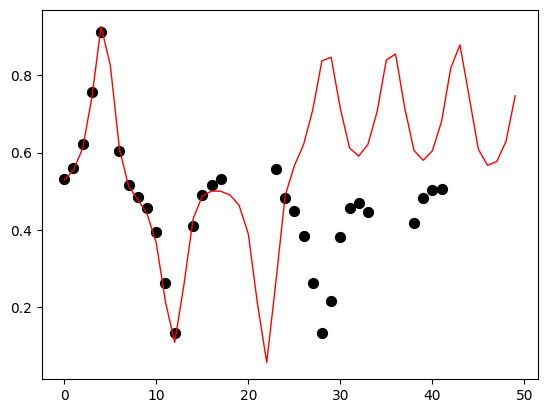

In [76]:
logistic_model = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')
logistic_model.fit(train_features_std, train_targets)

# Final prediction function
def final_prediction(patterns, sequence, pattern_matrices, eps):
    result = predict_one_step(patterns, sequence, pattern_matrices, eps)
    if result == 'N':
        return 'N'

    standardized_features = scaler.transform([result[1]])
    is_predictable = logistic_model.predict(standardized_features)[0]
    return result[0] if is_predictable else 'N'

# Prediction loop
final_predictions = []
T = 50
for t in range(T):
    prediction = final_prediction(pattern_set, np.append(x, final_predictions), pattern_matrix_train, eps=0.01)
    final_predictions.append(prediction)

print(final_predictions)

# Plotting
final_predictions_processed = [final_predictions[i] if final_predictions[i] != 'N' else np.nan for i in range(T)]
plt.plot(np.arange(T), y_true[:T], color='r', linewidth=1)
plt.scatter(np.arange(T), final_predictions_processed, color='black', s=50)


print("MAE:", calculate_mae(y_true[:T], final_predictions_processed))
print("MSE:", calculate_mse(y_true[:T], final_predictions_processed))

In [77]:
#baseline

print("MAE:", calculate_mae(y_true[:T], pred_))
print("MSE:", calculate_mse(y_true[:T], pred_))

MAE: 0.1423
MSE: 0.0686
